In [1]:
from utils import *
from terminal_models import FeedforwardUnicycle
from feedforward_network import FeedForwardNet
import torch
import matplotlib.pyplot as plt

In [2]:
net0 = torch.load('./nets/net0.pth')
net1 = torch.load('./nets/net1.pth')
net2 = torch.load('./nets/net2.pth')
net3 = torch.load('./nets/net3.pth')
net4 = torch.load('./nets/net4.pth')
net5 = torch.load('./nets/net5.pth')
net6 = torch.load('./nets/net6.pth')
net7 = torch.load('./nets/net7.pth')
net8 = torch.load('./nets/net8.pth')
net9 = torch.load('./nets/net9.pth')
net10 = torch.load('./nets/net10.pth')



In [3]:
def validation(net):
    data = random_positions(size = 50, xlim=[-2.,2.], ylim=[-2., 2.],zlim=[-np.pi/2, np.pi/2], as_tensor=False)

    terminal = FeedforwardUnicycle(net10)
    states, values = statesValues(init_positions=data,
                                  terminal_model=terminal, 
                                  as_tensor=True)
    
    with torch.no_grad():
        values_p = net(states).detach().numpy().reshape(-1,1)
    values = values.numpy().reshape(-1, 1)
    mean_error = np.abs(np.mean(values_p - values))
    print(f"Mean Error : {np.abs(np.mean(values_p - values))}")
    return mean_error

def validation_(net):
    data = grid_data(size=50,theta_lims=[-np.pi, np.pi], as_tensor=False)
    
    
    terminal = FeedforwardUnicycle(net10)
    states, values = statesValues(init_positions=data,
                                  terminal_model=terminal, 
                                  as_tensor=True) 
    
    with torch.no_grad():
        values_p = net(states).detach().numpy().reshape(-1,1)
    values = values.numpy().reshape(-1, 1)
    mean_error = np.abs(np.mean(values_p - values))
    print(f"Mean Error : {np.abs(np.mean(values_p - values))}")
    return mean_error


<Figure size 432x288 with 0 Axes>

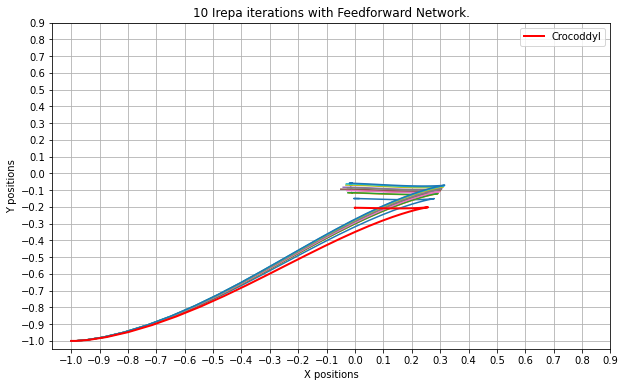

In [4]:
# Plot trajectories from the same point.



plt.clf()
fig, ax = plt.subplots(figsize=(10,6))

neural_nets = [net0, net1, net2, net3, net4, 
              net5,net6, net7, net8,
              net9, net10]




for neural_net in neural_nets:
    position = np.array([-1., -1., 0])
    terminal_model = FeedforwardUnicycle(neural_net)
    ddp = solve_problem(initial_configuration=position,
                       terminal_model=terminal_model,
                       precision=1e-6)
    
    xs_ = np.array(ddp.xs)
    xs  = xs_[:,0:2]

    ax.plot(xs[:,0], xs[:,1])

# Plot crocoddyl
position = np.array([-1., -1., 0])
ddp = solve_problem(initial_configuration=position, terminal_model=None, precision=1e-9, maxiters=1000)

ddp_xs = np.array(ddp.xs)
ax.plot(ddp_xs[:,0], ddp_xs[:,1], c = 'red',linewidth=2.0, label = 'Crocoddyl')

ax.legend()    
ax.set_xticks(np.arange(-1., 1, step=0.1))
ax.set_yticks(np.arange(-1., 1, step=0.1))
ax.grid()
ax.set_xlabel("X positions")
ax.set_ylabel("Y positions")
ax.set_title("10 Irepa iterations with Feedforward Network.")
plt.show()
#plt.savefig("3.png")

In [5]:
errors = []
for neural_net in neural_nets:
    errors.append(validation_(neural_net))

errors2 = []
for neural_net in neural_nets:
    errors2.append(validation(neural_net))

KeyboardInterrupt: 

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

plt.clf()
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(errors, "o",)
plt.plot(errors)
plt.xlabel("Training Iterations", fontsize = 20)
plt.ylabel("Mean Error = Predicted Value - True Value", fontsize = 15)
plt.grid()
plt.title("Increase in Mean Error with Irepa iterations")

In [ ]:
plt.clf()
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(errors2, "o",)
plt.plot(errors2)
plt.xlabel("Training Iterations", fontsize = 20)
plt.ylabel("Mean Error = Predicted Value - True Value", fontsize = 15)
plt.grid()
plt.title("Increase in Mean Error with Irepa iterations")

In [ ]:
def get_net_values(net, grid_points):
    states = torch.tensor(grid_points, dtype = torch.float32)
    with torch.no_grad():
            values_p = net(states).detach().numpy().reshape(-1,1)
     
    return values_p

def get_croc_vals(grid_points):
    values = []
    for initial_configuration in grid_points:
        model = crocoddyl.ActionModelUnicycle()
        model.costWeights = np.array([1., 1.]).T
        problem = crocoddyl.ShootingProblem(initial_configuration.T, [ model ] * 30, model)
        ddp         = crocoddyl.SolverDDP(problem)
        ddp.th_stop = 1e-9
    
        ddp.solve([], [], 1000)
        values.append([ddp.cost])
    return np.array(values).reshape(-1,1)
        




In [ ]:
grid = grid_data(size=75,theta_lims=[0., 0.], as_tensor=False)






In [ ]:
print(grid.shape)

In [ ]:
v_c = get_croc_vals(grid)

In [ ]:
v_p0 = get_net_values(net0, grid)


In [ ]:
v_p5 = get_net_values(net5,grid)
v_p10 = get_net_values(net10,grid)


In [ ]:

plt.clf()
fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharex=True, sharey ='row')
fig.subplots_adjust(left=0.02, bottom=0.2, top=0.94)

im0 = axs[0].scatter(x = grid[:,0], y = grid[:,1], c= v_c)
im1 = axs[1].scatter(x = grid[:,0], y = grid[:,1], c= v_p0)
im2 = axs[2].scatter(x = grid[:,0], y = grid[:,1], c= v_p5)
im3 = axs[3].scatter(x = grid[:,0], y = grid[:,1], c= v_p10)
fig.colorbar(im0, ax=axs[0])

axs[0].title.set_text("Crocoddyl")
axs[1].title.set_text("Iteration # 1")
axs[2].title.set_text("Iteration # 5")
axs[3].title.set_text("Iteration # 10")

#fig.colorbar(im0, ax=axs[0])
#fig.colorbar(im1, ax=axs[1])
fig.colorbar(im3, ax=axs[3])
